In [ ]:
import platform
print("CPU architecture:", platform.processor())
!cat /proc/cpuinfo | grep "model name" | uniq

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

CPU architecture: x86_64
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
name, driver_version, memory.total [MiB]
Tesla V100-SXM2-16GB, 535.104.05, 16384 MiB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from PIL import Image

Load the data

In [ ]:
X_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_train.npy')
X_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_val.npy')
X_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/X_test.npy')
y_train = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/MLMed/Brain_tumor/y_test.npy')

In [ ]:
y_train = np.array(pd.get_dummies(y_train))
y_val = np.array(pd.get_dummies(y_val))
y_test = np.array(pd.get_dummies(y_test))

In [ ]:
print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'y_val shape: {(X_val).shape}\n'
      f'X_val shape: {(y_val).shape}')

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

X_train shape: (4569, 256, 256, 3)
y_train shape: (4569, 4)
X_test shape: (1311, 256, 256, 3)
y_test shape: (1311, 4)
y_val shape: (1143, 256, 256, 3)
X_val shape: (1143, 4)


Data augmentation

In [ ]:
train_aug = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')
train_aug.fit(X_train)

val_aug = ImageDataGenerator()
val_aug.fit(X_val)

Define our model, train, test and evaluate

In [ ]:
img_shape = (256, 256, 3)
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    GlobalMaxPooling2D(),


    Dense(256,activation = "relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128,activation = "relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64,activation = "relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(4, activation = "softmax")
])

optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=True)

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                   

Train and evaluate our model

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,
                                            min_lr=0.000001, cooldown=2)

In [ ]:
batch = 64
epoch = 50

start = time.time()
history = model.fit(
                    train_aug.flow(X_train, y_train, batch_size = batch),
                    validation_data = val_aug.flow((X_val, y_val)),
                    epochs = epoch,
                    verbose = 1,
                    steps_per_epoch = (X_train.shape[0] // batch),
                    validation_steps = (X_val.shape[0] // batch),
                    callbacks = [learning_rate_reduction]
                    )

end = time.time()
runtime = end - start
print("Time elapsed: ", runtime, "s")

Epoch 1/50
71/71 [==============================] - 88s 936ms/step - loss: 1.5004 - accuracy: 0.4053 - val_loss: 1.3782 - val_accuracy: 0.3235 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 63s 885ms/step - loss: 1.2552 - accuracy: 0.5037 - val_loss: 1.3495 - val_accuracy: 0.4007 - lr: 1.0000e-04
Epoch 3/50
71/71 [==============================] - 63s 882ms/step - loss: 1.1753 - accuracy: 0.5436 - val_loss: 1.3015 - val_accuracy: 0.6360 - lr: 1.0000e-04
Epoch 4/50
71/71 [==============================] - 63s 878ms/step - loss: 1.0087 - accuracy: 0.6051 - val_loss: 1.2488 - val_accuracy: 0.4577 - lr: 1.0000e-04
Epoch 5/50
71/71 [==============================] - 64s 894ms/step - loss: 0.9058 - accuracy: 0.6455 - val_loss: 1.1833 - val_accuracy: 0.3732 - lr: 1.0000e-04
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 0.8643 - accuracy: 0.6675
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
71/71 [=======================

In [ ]:
model.save('/content/drive/MyDrive/MLMed/our_model.keras')

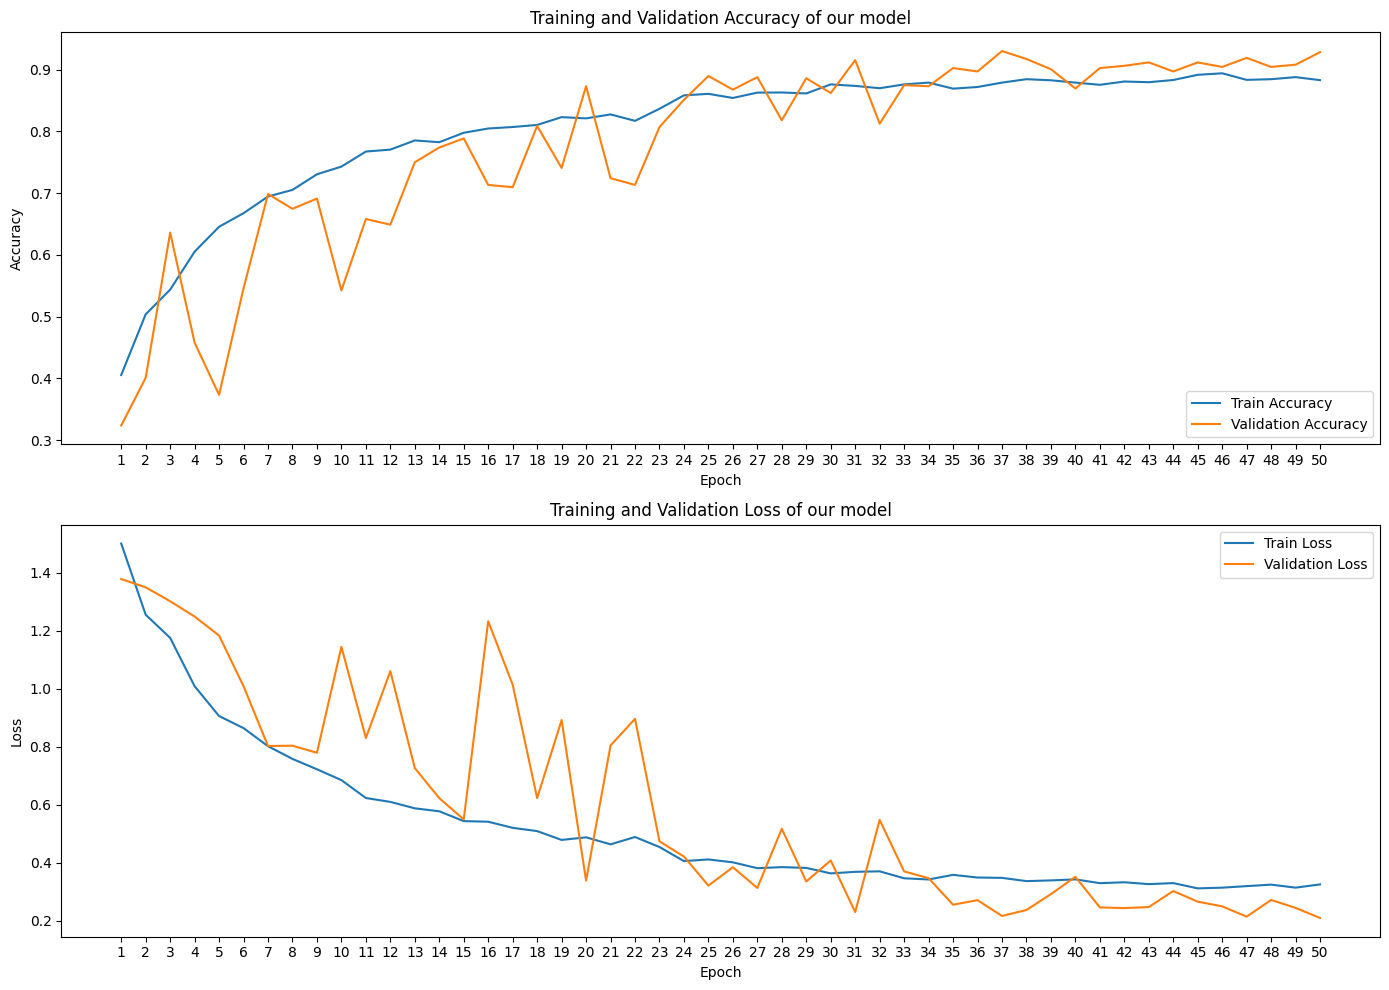

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
epochs_range = range(1,51)
# Accuracy subplot
ax1.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title(f'Training and Validation Accuracy of our model')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc = 'lower right')
ax1.set_xticks(list(epochs_range))

# Loss subplot
ax2.plot(epochs_range, history.history['loss'], label='Train Loss')
ax2.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
ax2.set_title(f'Training and Validation Loss of our model')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc = 'upper right')
ax2.set_xticks(list(epochs_range))

plt.tight_layout()
plt.show()

In [ ]:
y_true = np.argmax(y_test, axis = 1)
y_pred= np.argmax(model.predict(X_test), axis = 1)

print(classification_report(y_true, y_pred))

41/41 [==============================] - 4s 92ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       300
           1       0.87      0.64      0.74       306
           2       0.89      0.99      0.94       405
           3       0.83      0.99      0.90       300

    accuracy                           0.87      1311
   macro avg       0.87      0.87      0.86      1311
weighted avg       0.88      0.87      0.87      1311



In [ ]:
dict = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
classname = [dict[label] for label in np.unique(y_pred)]
print(classname)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


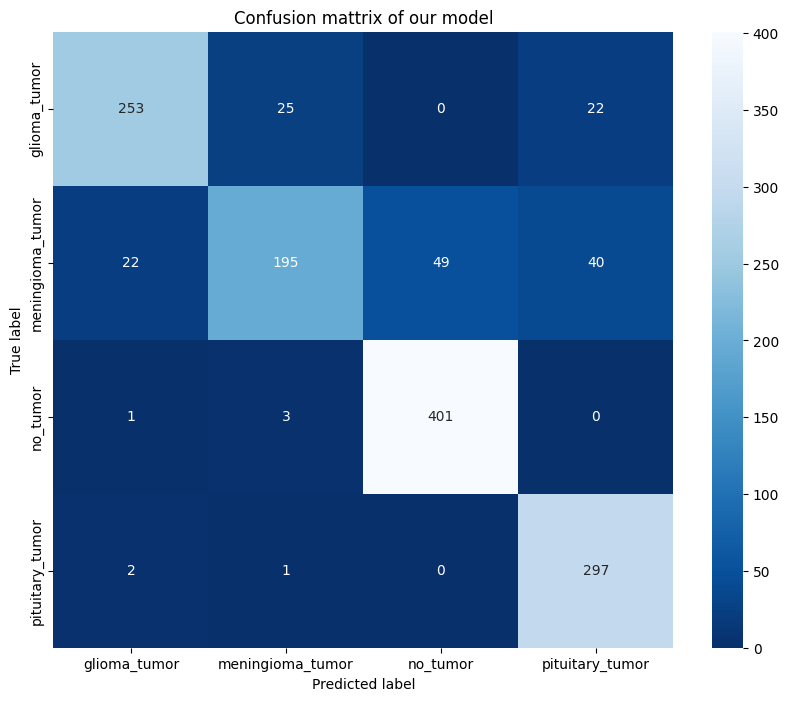

In [ ]:
plt.figure(figsize = (10, 8))
hm = sns.heatmap(confusion_matrix(y_true, y_pred), annot = True, fmt = 'd', cmap = 'Blues_r',
                 xticklabels = classname, yticklabels = classname)
plt.title('Confusion mattrix of our model')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
index = np.random.choice(len(X_test), size=100, replace=False)

fig, axs = plt.subplots(20, 5, figsize=(25, 150))

axs = axs.flatten()

for i, idx in enumerate(index):
    axs[i].imshow(X_test[idx])
    label = dict[y_pred[idx]]
    label_true = dict[y_true[idx]]
    axs[i].set_xlabel('pred: ' + label, fontsize=22, color='red')
    axs[i].set_ylabel('true: ' + label_true, fontsize=22, color='red')
    axs[i].set_xticklabels(axs[i].get_xticks(), rotation=90)
    axs[i].axis('on')

plt.tight_layout()

plt.show()

Output hidden; open in https://colab.research.google.com to view.